# 1. Reading in the Data

In [2]:
# Loading the libraries
import pandas as pd
import numpy as np
import random

In [11]:
# Loading the data
artist = pd.read_table("Data/Artists.dat")
tags = pd.read_table("Data/tags.dat", sep = '\t')
user_artists = pd.read_table("Data/user_artists.dat")
user_tagged_artists = pd.read_table("Data/user_taggedartists.dat")

Quick view of the data loaded

In [7]:
artist.head(2)

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg


In [12]:
tags.head(2)

,tagID,tagValue
0,1,metal
1,2,alternative metal


In [9]:
user_artists.head(2)

,userID,artistID,weight
0,2,51,13883
1,2,52,11690


In [13]:
user_tagged_artists.head(2)

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009


### Checking for missing values

In [17]:
artist.isna().sum()

id              0
name            0
url             0
pictureURL    444
dtype: int64

In [18]:
tags.isna().sum()

tagID       0
tagValue    0
dtype: int64

In [20]:
user_artists.isna().sum()

userID      0
artistID    0
weight      0
dtype: int64

In [21]:
user_tagged_artists.isna().sum()

userID      0
artistID    0
tagID       0
day         0
month       0
year        0
dtype: int64

### Creating the Content-Based Matrix

To create the content based matrix `cbased`, we are joining `user_tagged_artists` and `tags` dataframes 

In [22]:
# First matrix for content-based: merge user_taggedartists and tags
cbased = pd.merge(user_tagged_artists,tags, right_on = 'tagID',left_on = 'tagID', how= 'inner')
cbased.head()

,userID,artistID,tagID,day,month,year,tagValue
0,2,52,13,1,4,2009,chillout
1,2,63,13,1,4,2009,chillout
2,2,73,13,1,4,2009,chillout
3,2,94,13,1,4,2009,chillout
4,2,6177,13,1,5,2009,chillout


In [25]:
# The cbased dataset contains years ranging from 1956 to 2011
# Hence let's add a new variable `Rating` with a rating for each year
cbased.year.unique()

array([2009, 2007, 2010, 2011, 2008, 2006, 2005, 1956, 1979, 1957],
      dtype=int64)

In [26]:
# Creating the Rating for each year, starting for the oldest year to the most recent year
cbased.loc[cbased.year ==1956, 'Rating'] = 1
cbased.loc[cbased.year ==1957, 'Rating'] = 2
cbased.loc[cbased.year ==1979, 'Rating'] = 3
cbased.loc[cbased.year ==2005, 'Rating'] = 4
cbased.loc[cbased.year ==2006, 'Rating'] = 5
cbased.loc[cbased.year ==2007, 'Rating'] = 6
cbased.loc[cbased.year ==2008, 'Rating'] = 7
cbased.loc[cbased.year ==2009, 'Rating'] = 8
cbased.loc[cbased.year ==2010, 'Rating'] = 9
cbased.loc[cbased.year ==2011, 'Rating'] = 10

In [28]:
# The final content-based dataframe to be used for modeling
cbased.head()

,userID,artistID,tagID,day,month,year,tagValue,Rating
0,2,52,13,1,4,2009,chillout,8.0
1,2,63,13,1,4,2009,chillout,8.0
2,2,73,13,1,4,2009,chillout,8.0
3,2,94,13,1,4,2009,chillout,8.0
4,2,6177,13,1,5,2009,chillout,8.0


### Creating the Matrix for Collaborative-filtering

In [32]:
user_artists.head(2)

,userID,artistID,weight,Rating
0,2,51,7228.01,10
1,2,52,7228.01,10


Text(0, 0.5, 'Frequencies')

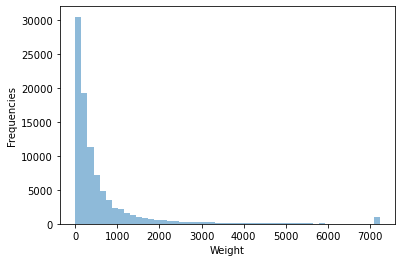

In [47]:
ax = user_artists.weight.plot.hist(bins=50,alpha=0.5)
ax.set_xlabel("Weight")
ax.set_ylabel("Frequencies")

To better deal with this skewed weights, let us create our ranking off of the weights based on the percentiles

In [29]:
user_artists.weight.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
#user_artists.weight.quantile([0.01])

user_artists.loc[user_artists.weight > 7228.01,'weight'] = 7228.01
user_artists.loc[user_artists.weight <2 ,'weight'] = 2

# We will create our ratings based on the percentiles shown above
user_artists.loc[user_artists.weight >= 7228.01,'Rating'] = 10
user_artists.loc[(user_artists.weight < 83),'Rating'] = 1

user_artists.loc[(user_artists.weight >= 1387.00) & (user_artists.weight < 7228),'Rating'] = 9
user_artists.loc[(user_artists.weight >= 764.00) & (user_artists.weight < 1387),'Rating'] = 8
user_artists.loc[(user_artists.weight >= 506) & (user_artists.weight < 764),'Rating'] = 7
user_artists.loc[(user_artists.weight >= 358) & (user_artists.weight < 506),'Rating'] = 6
user_artists.loc[(user_artists.weight >= 260) & (user_artists.weight < 358),'Rating'] = 5
user_artists.loc[(user_artists.weight >= 188) & (user_artists.weight < 260),'Rating'] = 4
user_artists.loc[(user_artists.weight >= 131) & (user_artists.weight < 188),'Rating'] = 3
user_artists.loc[(user_artists.weight >= 83) & (user_artists.weight < 131),'Rating'] = 2

# We have the base table for collaborative filtering
user_artists.loc[:,'Rating'] = user_artists.loc[:,'Rating'].astype('int')
user_artists.head()
nusers = user_artists

In [30]:
nusers.head()

,userID,artistID,weight,Rating
0,2,51,7228.01,10
1,2,52,7228.01,10
2,2,53,7228.01,10
3,2,54,7228.01,10
4,2,55,7228.01,10


# 2. Building the Models

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
#Asign requiered columns
user_artists = user_artists[['artistID','weight', 'Rating']]

In [9]:
# train-test split
random.seed(1)
train, test = train_test_split(user_artists, test_size=0.3, random_state=42)

# reset index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [10]:
#Split train and test
from surprise import Dataset, Reader
random.seed(1)

reader = Reader(rating_scale=(1, 10))
df_train_ub = Dataset.load_from_df(train,reader).build_full_trainset()
df_test_ub = list(test.itertuples(index=False, name=None))

In [11]:
from surprise import KNNBasic
#User based collaborative filltering
# set option to cosine similarity and user-based collaborative filtering
options = {'name':'Pearson', 'user_based':True}

# select 15 most similar users (min 5)
ub = KNNBasic(k=15, min_k=5, sim_options=options)

# fit on training set
ub.fit(df_train_ub)

# predict
ub_pred = ub.test(df_test_ub)
df_ub_pred = pd.DataFrame(ub_pred)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [15]:
df_ub_pred.head()

,uid,iid,r_ui,est,details
0,16513,82.0,1,4.61331,"{'was_impossible': True, 'reason': 'Not enough..."
1,3746,403.0,6,6.00000,"{'actual_k': 15, 'was_impossible': False}"
2,8841,41.0,1,4.61331,"{'was_impossible': True, 'reason': 'Not enough..."
3,5270,238.0,4,4.00000,"{'actual_k': 15, 'was_impossible': False}"
4,295,833.0,8,8.00000,"{'actual_k': 15, 'was_impossible': False}"


In [12]:
from IESEGRecSys.Functions import *

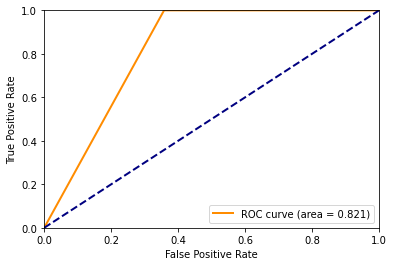

,User_based_15
RMSE,2.002186
MAE,1.180014
Recall,1.000000
Precision,0.809281
F1,0.894588
AUC,0.821002
NDCG,0.970577


In [13]:
#Evaluate model
ub_res1 = prediction_metrics(df_ub_pred.est, df_ub_pred.r_ui)
ub_res2 = classification_metrics(df_ub_pred.est, df_ub_pred.r_ui,4)
ub_res3 = ranking_metrics(df_ub_pred, threshold=4, topn=10)

# append results
ub_res = ub_res1.append(ub_res2).append(ub_res3).rename(columns={'value':'User_based_15'})
ub_res

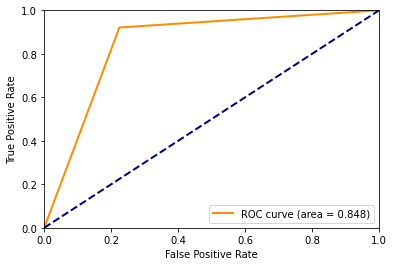

In [14]:
#Cluster-based collaborative filtering
from surprise import CoClustering
random.seed(1)
# select 10 user-based and 10 item based clusters
cocl = CoClustering(n_cltr_u=10, n_cltr_i=10, n_epochs=50, random_state=42)

# fit on training set
cocl.fit(df_train_ub)

# predict
cocl_pred = cocl.test(df_test_ub)
df_cocl_pred = pd.DataFrame(cocl_pred)
cocl_res1 = prediction_metrics(df_cocl_pred.est, df_cocl_pred.r_ui)
cocl_res2 = classification_metrics(df_cocl_pred.est, df_cocl_pred.r_ui,4)
cocl_res3 = ranking_metrics(df_cocl_pred, threshold=4, topn=10)
cocl_res = cocl_res1.append(cocl_res2).append(cocl_res3).rename(columns={'value':'CoClust_10_10'})

### Item based 

In [17]:
cbased_unpivot = nusers[['userID','artistID','Rating']]

In [18]:
# train-test split
random.seed(1)
trainIB, testIB = train_test_split(cbased_unpivot, test_size=0.3, random_state=42)

# reset index
trainIB = trainIB.reset_index(drop=True)
testIB = testIB.reset_index(drop=True)
#cbased_unpivot=cbased_unpivot[cbased_unpivot['Rating']!=0]


In [22]:
trainIB

,userID,artistID,Rating
0,680,4562,7
1,2084,1239,4
2,1959,295,5
3,1766,681,3
4,683,1027,7
...,...,...,...
64978,132,55,8
64979,1223,1519,7
64980,1734,1457,5
64981,20,746,5


In [19]:
print('------ Train ------')
print('Nr items:', len(trainIB.userID.unique()))
print('Nr users:', len(trainIB.userID.unique()))

print('\n------ Test ------')
print('Nr items:', len(testIB.userID.unique()))
print('Nr users:', len(testIB.userID.unique()))

print('\nNr new items:', len(set(testIB.userID).symmetric_difference(set(trainIB.userID))))
print('Nr new users:', len(set(testIB.userID).symmetric_difference(set(trainIB.userID))))

------ Train ------
Nr items: 1889
Nr users: 1889

------ Test ------
Nr items: 1884
Nr users: 1884

Nr new items: 11
Nr new users: 11


In [20]:
from surprise import Dataset, Reader
random.seed(1)
reader = Reader(rating_scale=(1, 5))

df_train = Dataset.load_from_df(trainIB, reader).build_full_trainset()
df_test = list(testIB.itertuples(index=False, name=None))

In [21]:
# set option to pearson correlation and item-based collaborative filtering
options = {'name':'pearson', 'user_based':False}
random.seed(1)
# select 20 most similar items (min 5)
ib = KNNBasic(k=20, min_k=5, sim_options=options)

# fit on training set
ib.fit(df_train)

# predict
ib_pred = ib.test(df_test)
df_ib_pred = pd.DataFrame(ib_pred)

Computing the pearson similarity matrix...
Done computing similarity matrix.


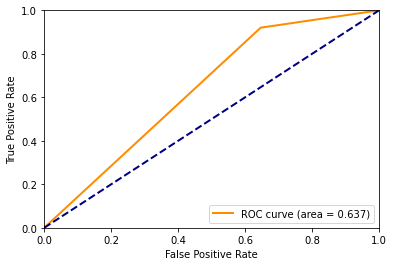

,Item_based_20
RMSE,2.499128
MAE,2.088867
Recall,0.920393
Precision,0.683740
F1,0.784610
AUC,0.636843
NDCG,0.843716


In [22]:
ib_res1 = prediction_metrics(df_ib_pred.est, df_ib_pred.r_ui)
ib_res2 = classification_metrics(df_ib_pred.est, df_ib_pred.r_ui,4)
ib_res3 = ranking_metrics(df_ib_pred, threshold=4, topn=10)
ib_res = ib_res1.append(ib_res2).append(ib_res3).rename(columns={'value':'Item_based_20'})
ib_res

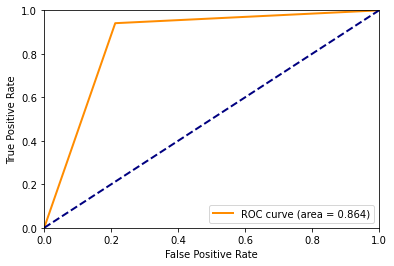

,Item_based_20
RMSE,1.479663
MAE,0.901166
Recall,0.941013
Precision,0.874250
F1,0.906403
AUC,0.864430
NDCG,0.988614


In [23]:
# Hybrid system 1:

hybrid = pd.merge(df_ub_pred,df_cocl_pred, on = ['uid','iid'], how = 'inner').drop(columns = ['details_x'])
hybrid['rating'] = (hybrid['est_x'] + hybrid['est_y'])/2
hybrid = hybrid.drop(columns = ['r_ui_y','est_y','est_x'])
hybrid = hybrid[['uid','iid','r_ui_x','rating','details_y']]
hybrid.columns = ['uid','iid','r_ui','est','details']

# Evaluating
ib_res1 = prediction_metrics(hybrid.est, hybrid.r_ui)
ib_res2 = classification_metrics(hybrid.est, hybrid.r_ui,4)
ib_res3 = ranking_metrics(hybrid, threshold=4, topn=10)
ib_res = ib_res1.append(ib_res2).append(ib_res3).rename(columns={'value':'Item_based_20'})
ib_res

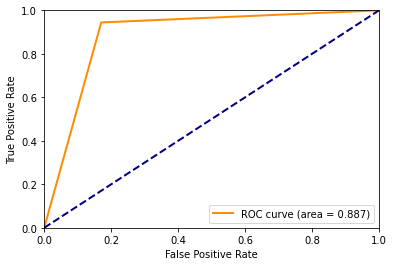

,Item_based_20
RMSE,1.616659
MAE,1.307123
Recall,0.944399
Precision,0.826978
F1,0.881797
AUC,0.887041
NDCG,0.902208


In [50]:
# Hybrid system 2:

hybrid = pd.merge(df_ib_pred,df_cocl_pred, right_on = ['iid','r_ui'], left_on = ['uid','r_ui'], how = 'inner').drop(columns = ['details_x'])
hybrid['rating'] = (hybrid['est_x'] + hybrid['est_y'])/2
hybrid = hybrid.drop(columns = ['uid_y','iid_y','est_y','est_x'])
hybrid = hybrid[['uid_x','iid_x','r_ui','rating','details_y']]
hybrid.columns = ['uid','iid','r_ui','est','details']

# Evaluating
ib_res1 = prediction_metrics(hybrid.est, hybrid.r_ui)
ib_res2 = classification_metrics(hybrid.est, hybrid.r_ui,4)
ib_res3 = ranking_metrics(hybrid, threshold=4, topn=10)
ib_res = ib_res1.append(ib_res2).append(ib_res3).rename(columns={'value':'Item_based_20'})
ib_res